In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *

In [2]:
n = 500
T = 1
d = 2
B = 100  # Number of p-values to compute

# Generate an SBM
As, tau = make_iid(n, T, iid_prob=0.9)
A_obs = As[0]


In [16]:

# Bootstrap
A_boots = parametric_bootstrap(A_obs, d=d, B=B)

# Testing
p_vals = []
for i in range(B):
    A_boots_sample = A_boots[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_boots_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)



/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:57: UserWarning:

P_hat contains values outside of [0,1]. Consider increasing n.



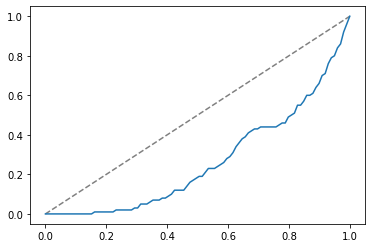

0.0

In [9]:
# Plot the cummulative p-value distribution
# If the bootstrap is good, it should be approximately uniform
# If below uniform, the bootstrap is conservative (invalid variance estimates?)
# If above uniform, the bootstrap is invalid (conservative variance estimates?)
plot_power(p_vals)

Try row sampling with replacement to get "bootstrap" matrices

In [17]:
# Bootstrap
A_row_jumble = row_sample_with_replacement(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_row_jumble_sample = A_row_jumble[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_row_jumble_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)



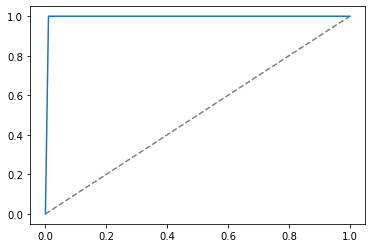

1.0

In [18]:
plot_power(p_vals)

In [22]:
plot_embedding(UASE([A_obs, A_row_jumble[0], A_row_jumble[1]], 2), n, 3, tau)

In [27]:
def edgelist_jackknife(A, B):
    """
    Pick a random entry and set it to zero
    """
    n = A.shape[0]
    A_star = np.zeros((B, n, n))

    for i in range(B):
        A_star[i] = A.copy()
        for j in range(3):
            idx = np.random.choice(n, size=2, replace=True)
            A_star[i][idx[0], idx[1]] = 0
            A_star[i][idx[1], idx[0]] = 0

    return A_star

# Bootstrap
A_jk = edgelist_jackknife(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_jk_sample = A_jk[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_jk_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)


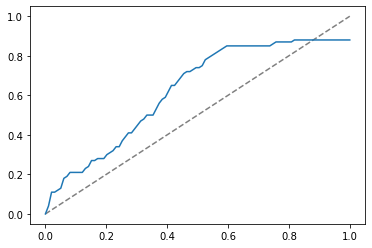

0.13

In [28]:
plot_power(p_vals)

In [29]:
plot_embedding(UASE([A_obs, A_jk[0], A_jk[1]], 2), n, 3, tau)